In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras_tuner
from kerastuner.tuners import RandomSearch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional, LSTM, Flatten, GlobalMaxPool1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2024-04-12 09:54:44.185073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 09:54:44.185137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 09:54:44.186918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 09:54:44.194359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_665648/1506233148.py:7: DeprecationWar

In [2]:
train = pd.read_csv('emotions_all.csv') # My dataset

train.head() # Display the first 5 rows of the train dataset

,sentence,emotion
0,That game hurt.,sadness
1,Man I love reddit.,happiness
2,Right? Considering its such an important docum...,happiness
3,"He isn't as big, but he's still quite popular....",disgust
4,That's crazy; I went to a super [RELIGION] hig...,happiness


In [3]:
# Importing the test dataset
test = pd.read_csv('test_individual.csv', sep='\t')

test.head() #Display the first 5 rows of the test dataset

,id,sentence
0,0,I get sad when I see a sick animal.
1,1,Getting punched in the face like that makes my...
2,2,I get anxious near the end of the block.
3,3,being awoken to a shadowy figure at the edge o...
4,4,I am annoyed that my brother didn't wash his d...


In [4]:
# Extracting the sentences and labels from the training and testing datasets.
train_sentences = train['sentence'].values
train_labels = train['emotion'].values
test_sentences = test['sentence'].values

In [5]:
# Preprocess labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded)

In [6]:
# Tokenize sentences
tokenizer = Tokenizer(oov_token='<OOV>', num_words=1000000)
tokenizer.fit_on_texts(train_sentences)
tokenizer.fit_on_texts(test_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [7]:
# Pad sequences for training data
max_length = max(len(x) for x in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

# Pad sequences for testing data using the same max_length
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [8]:
# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels_one_hot, test_size=0.2, random_state=42)

In [9]:
# Showing all the unique values in the emotion column
unique_emotions = train['emotion'].unique()
num_emotions = len(unique_emotions)
print("Unique emotions:", unique_emotions)
print("Number of unique emotions:", num_emotions)

Unique emotions: ['sadness' 'happiness' 'disgust' 'surprise' 'anger' 'fear']
Number of unique emotions: 6


In [10]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=231),
        Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True)),
        Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)),
        Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'),
        Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)),
        Dense(num_emotions, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Adjust based on computational budget
    executions_per_trial=2,
    directory='my_dir',
    project_name='emotion_classification_6'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128, callbacks=[early_stopping])

Trial 3 Complete [00h 54m 12s]
val_accuracy: 0.9204998910427094

Best val_accuracy So Far: 0.9204998910427094
Total elapsed time: 00h 54m 57s


In [11]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

In [17]:
y_pred = best_model.predict(X_val) # For confusion matrix
# y_pred = best_model.predict(test_padded) # For Kaggle submission

45/45 [==============================] - 1s 17ms/step


In [13]:
# Convert predictions to label indices
predicted_class_indices = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Use the LabelEncoder to decode the predictions to original labels
predicted_emotions = label_encoder.inverse_transform(predicted_class_indices)

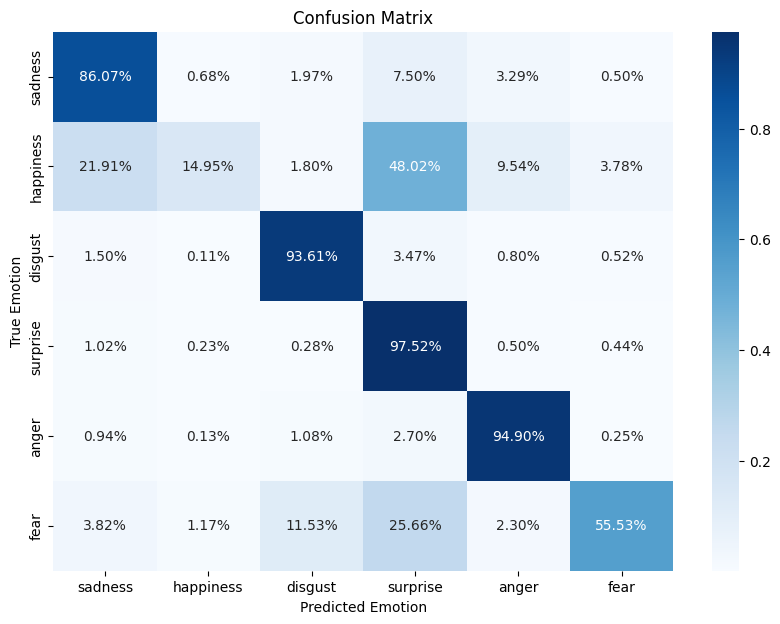

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_class_indices)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=unique_emotions, yticklabels=unique_emotions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()

In [ ]:
test.head()

In [ ]:
# Rename Predicted Emotion column
test = test.rename(columns={'Predicted Emotion': 'emotion'})

# Drop sentence column
test = test.drop(columns=['sentence'])

test.head()

In [ ]:
test.to_csv('rnn_model_max_5_hptuning_newdata.csv', index=False)